In [104]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pytesseract import Output

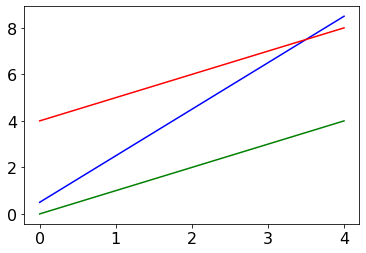

In [123]:
plt.rcParams.update({'font.size': 16,
                     'savefig.dpi': 300})
# Create an image plot

x = np.linspace(0,4,100)
plt.plot(x,x, 'g')
plt.plot(x, 2*x + 0.5, 'b')
plt.plot(x, x + 4, 'r')

plt.savefig("plots/three_linear_graphs.png")

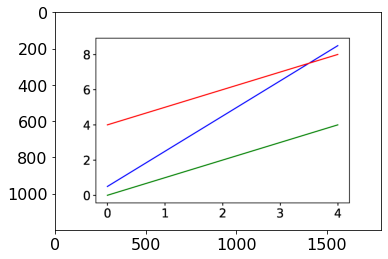

In [124]:
use_image = "plots/three_linear_graphs.png"

# Load image into numpy array and display it
base_img = cv2.imread(use_image)

def show_image(img):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(rgb)

show_image(base_img)

In [125]:
class Rect:
    def __init__(self, x,y,w,h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    @property
    def area(self):
        return (self.x+self.w) * (self.y+self.h)

    def intersect(self, other):
        no_x = self.x + self.w < other.x or self.x > other.x + other.w
        no_y = self.y + self.h < other.y or self.y > other.y + other.h
        return not no_x and not no_y

    def __str__(self):
        return f"({self.x}, {self.y}, {self.w}, {self.h})"

    def __repr__(self):
        return str(self)

In [126]:
def apply_min_contour_distance(rectangle_list):
    cleaned_contours = []

    # create a copy
    candidates = rectangle_list[:]
    while candidates:
        r1 = candidates[0]
        similars = [r1]
        # get all similar rects
        for r2 in candidates:
            if r1 != r2 and r1.intersect(r2):
                similars.append(r2)
        
        # use the box with the largest area
        areas = [r.area for r in similars]
        largest = areas.index(max(areas))
        cleaned_contours.append(similars[largest])
        
        # remove them as candidates
        for c in similars:
            candidates.remove(c)
    return cleaned_contours

def filter_by_area(rects, std_factor=1.5):

    # filter contours that are too far from the most n_boxes
    areas = np.array([r.area for r in rects])
    median = np.median(areas)
    std = np.std(areas)

    # only keep rectangles with an area of less than std_factor std
    rects = filter(lambda r: abs(r.area - median) <= std_factor * std, rects)
    return  list(rects)

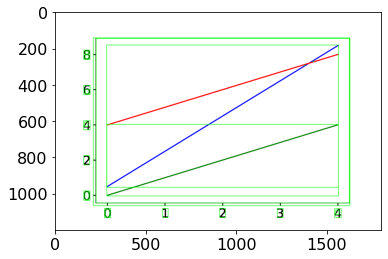

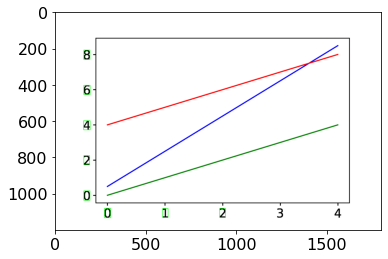

In [127]:
img_gray = cv2.cvtColor(base_img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rectangles = [Rect(*cv2.boundingRect(c)) for c in contours]

img2 = base_img.copy()
for c in rectangles:
    img2 = cv2.rectangle(img2, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)

show_image(img2)

filtered = apply_min_contour_distance(rectangles)
filtered = filter_by_area(filtered)
img3 = base_img.copy()
for c in filtered:
    img3 = cv2.rectangle(img3, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)
show_image(img3)


('1', (592, 1056, 30, 75))
('2', (906, 1055, 32, 76))
('0', (272, 1055, 34, 77))
('2', (158, 790, 57, 51))
('4', (157, 598, 61, 50))
('6', (158, 403, 60, 51))
('8', (158, 209, 59, 52))


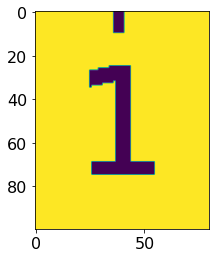

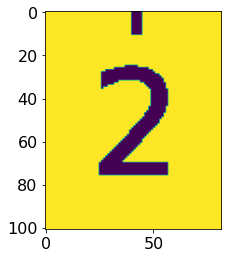

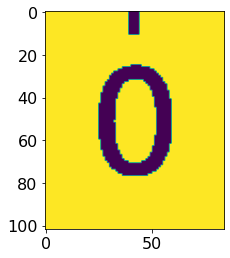

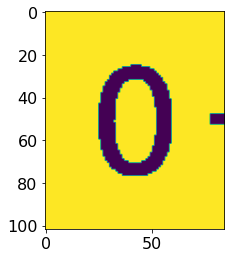

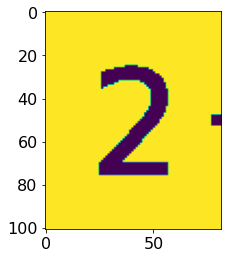

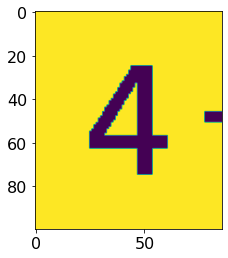

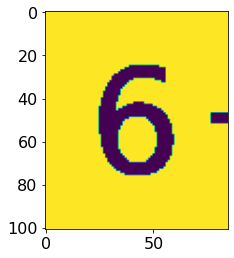

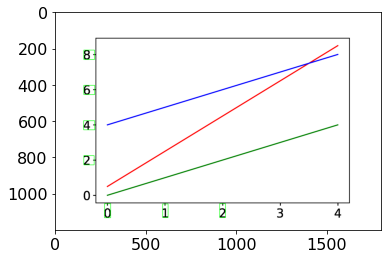

In [128]:
def add_border_to_box(r, img_shape, border_size=25):
    x = max(0, r.x - border_size)
    y = max(0, r.y - border_size)
    w = min(r.w + 2 * border_size, img_shape[0])
    h = min(r.h + 2 * border_size, img_shape[1])
    return Rect(x,y,w,h)

img_ocr = cv2.cvtColor(base_img.copy(), cv2.COLOR_BGR2GRAY)
img_ocr = cv2.threshold(img_ocr, 0, 255, cv2.THRESH_OTSU)[1]

letter_boxes = []

for rect in filtered:
    # extra borders to make the contours inside of the rectangle
    rect = add_border_to_box(rect, base_img.shape)
    roi = img_ocr[rect.y : rect.y + rect.h, rect.x : rect.x + rect.w]
    fig, ax = plt.subplots()
    plt.imshow(roi)
    d = pytesseract.image_to_data(roi, output_type=Output.DICT, config=f'--psm 13 -c tessedit_char_whitelist=0123456789')
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            char_rect = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            original = Rect(rect.x + char_rect[0], rect.y + char_rect[1], char_rect[2], char_rect[3])
            letter_boxes.append((d["text"][i], original))
            print(letter_boxes[-1])

ocr_img = base_img.copy()
for c, box in letter_boxes:
    ocr_img = cv2.rectangle(ocr_img, (box.x, box.y), (box.x + box.w, box.y + box.h), (0,255,0), 2)

plt.imshow(ocr_img)


In [129]:
class PixelToLabelLookup:
    def __init__(self, all_label_boxes):
        """
        Class to convert found pixels (data values) to the corresponding value as indicated by the axis labels
        :param all_label_boxes:
        """
        self.x, self.y = self._separate_labels_for_axes(all_label_boxes)
        print(f"X-Labels: {self.x}")
        print(f"Y-Labels: {self.y}")
        self.x_func, self.y_func = self._create_lookup_fns()

    @staticmethod
    def _separate_labels_for_axes(labels, max_pixel_error=30):
        y_labels = []
        x_labels = []
        for val, r in sorted(labels, key=lambda t: t[1].y):
            val = int(val)
            if not y_labels:
                y_labels.append((val, r))
            elif abs(r.x - y_labels[-1][1].x) < max_pixel_error:
                # check if it is an y value
                y_labels.append((val, r))
            else:
                x_labels.append((val, r))
        return x_labels, y_labels

    def linear_regression(self, mean_points):
        points = np.array(mean_points).T
        assert len(points.shape) == 2

        x, y = points[0], points[1]

        s_xy = np.sum((x - x.mean()) * (y - y.mean()))
        s_xx = np.sum((x - x.mean()) ** 2)

        b = float(s_xy) / s_xx
        intercept = y.mean() - b * x.mean()

        def reg_fn(px):
            return np.round(intercept + b * px, 2)

        return reg_fn

    def _create_lookup_fns(self):
        mean_points_x = [(r.x + r.w / 2, val) for val, r in self.x]
        mean_points_y = [(r.y + r.h / 2, val) for val, r in self.y]
        print(mean_points_x)
        print(mean_points_y)
        return self.linear_regression(mean_points_x), self.linear_regression(mean_points_y)

    def lookup(self, px):
        return self.x_func(px[0]), self.y_func(px[1])

    def __call__(self, arr: np.ndarray):
        # lookup for a numpy array along the last dimension.
        values = np.apply_along_axis(self.lookup, -1, arr)
        return values

label_lookup = PixelToLabelLookup(letter_boxes)

X-Labels: [(2, (906, 1055, 32, 76)), (0, (272, 1055, 34, 77)), (1, (592, 1056, 30, 75))]
Y-Labels: [(8, (158, 209, 59, 52)), (6, (158, 403, 60, 51)), (4, (157, 598, 61, 50)), (2, (158, 790, 57, 51))]
[(922.0, 2), (289.0, 0), (607.0, 1)]
[(235.0, 8), (428.5, 6), (623.0, 4), (815.5, 2)]


found 3 colors/graphs


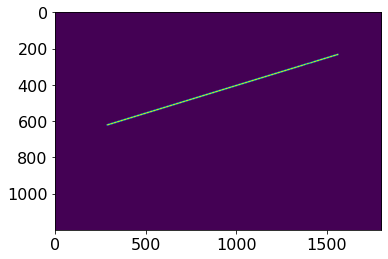

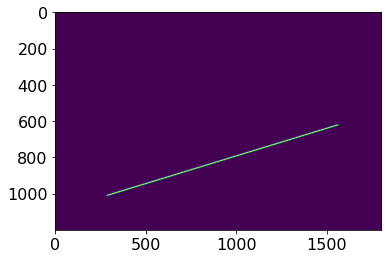

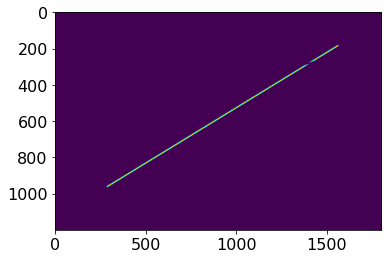

In [130]:
# If we have multiple graphs in a plot, we separate them by color.
# Change into the HSV color space because it better represents the perceived color.
# as we do not have many different colors we can easily threshold them to separate values, using the first (hue) value only
# problems: this does not work for black graphs

def separate_by_color(img_):
    hsv_img = cv2.cvtColor(img_, cv2.COLOR_BGR2HSV)

    hue_values = np.transpose(hsv_img, (2,0,1))[0].flatten()

    # Get the most frequent hue values, i.e. present colors without noise
    unq, counts = np.unique(hue_values, return_counts=True)
    unique_threshold = 20
    colors = unq[counts > unique_threshold]

    color_masks = {}
    for c in colors:
        # define a range to make red possible as it is [0,255,255]
        lower = np.array([c,50,50])
        upper = np.array([c,255,255])

        mask = cv2.inRange(hsv_img, lower, upper)
        color_masks[c] = mask
        plt.subplots()
        plt.imshow(mask)
    return color_masks

color_masks = separate_by_color(base_img)
print(f"found {len(color_masks)} colors/graphs")

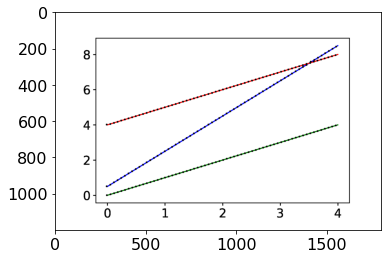

In [131]:
from collections import defaultdict

def get_pixels_for_one_graph(graph_mask, x_resolution=10):
    """

    :param graph_mask: np.ndarray of shape (height, width)
    :param x_resolution: the space between 2 adjacent points
    :return:
    """
    # find non-zero indices
    data = np.argwhere(graph_mask.T > 0)
    data_points_agg = defaultdict(list)
    np.apply_along_axis(lambda row: data_points_agg[row[0]].append(row[1]), -1, data)

    # use the median value for each x value ( as the stroke of a lineplot might be thicker)
    points = np.array([[x, np.median(y)] for x,y in data_points_agg.items()], dtype=np.int)

    # down_scale the points to the given resolution
    down_scale = points[np.arange(0, len(points), x_resolution)]

    return down_scale

# show the data_points in the plot
cat_img = base_img.copy()
pixel_data = {}
real_data = {}
for c, m in color_masks.items():
    dp = get_pixels_for_one_graph(m, 20)
    real_values = label_lookup(dp)
    pixel_data[c] = dp
    real_data[c] = real_values
    for d in dp:
        cv2.circle(cat_img, tuple(d), radius=5, color=(0,0,0), thickness=cv2.FILLED)
show_image(cat_img)

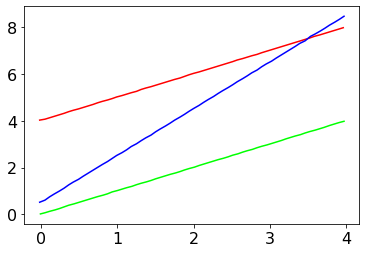

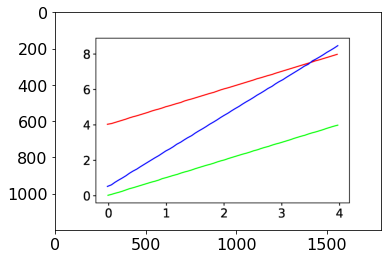

In [133]:
# Pixel data to actual label values
plt.figure()
for c, d in real_data.items():
    color_hue = np.array([[[c, 255,255]]], dtype=np.uint8)
    color_rgb = cv2.cvtColor(color_hue, cv2.COLOR_HSV2RGB).flatten()
    x,y = d.T
    plt.plot(x,y, color=tuple(color_rgb / 255.))

res = "plots/result.png"
plt.savefig(res)

Base-img vs recreated image


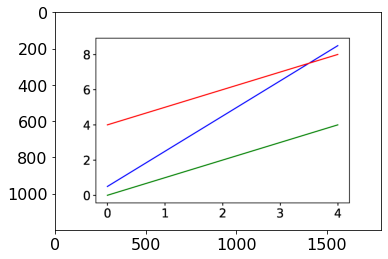

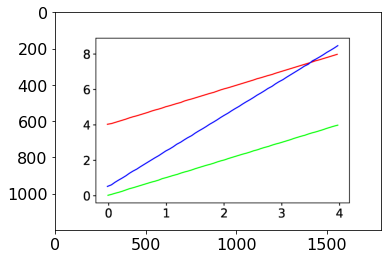

In [134]:
print("Base-img vs recreated image")
show_image(base_img)
show_image(cv2.imread(res))

